Предсказание суммарной стоимости акций starBucks

> Источники сего творчества:
> 
> - lstm нейросети и предстказания + датасет
> 
>     https://cnvrg.io/pytorch-lstm/
> 
> - график плотности распределения
> 
>     https://seaborn.pydata.org/generated/seaborn.kdeplot.html
> 
> - квантили
> 
>     https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy
>
> - коррелограммы
> 
>     https://habr.com/ru/articles/207160/

# Люди добрые, берите другой датасет, с ВВП стран или объемами урожая например или другие акции и т.д.

> ВВП стран и регионов
> 
> https://www.kaggle.com/code/stieranka/predicting-gdp-world-countries
>
> Ценные бумаги
>
> https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)

In [2]:
df['MA'] = df['Volume'].rolling(window=5).mean()
df['STD'] = df['Volume'].rolling(window=5).std()

df['MA'] = df['MA'].fillna(0)
df['STD'] = df['STD'].fillna(0)

In [3]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA,STD
Date,,,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.847794,4921900,0.0,0.000000e+00
2019-12-12,88.000000,88.889999,87.540001,88.209999,81.341652,10282100,0.0,0.000000e+00
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.765823,6714100,0.0,0.000000e+00
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.867256,6705600,0.0,0.000000e+00
2019-12-17,88.870003,88.970001,87.470001,88.129997,81.267868,7296900,7184120.0,1.947931e+06
2019-12-18,88.389999,88.849998,87.820000,87.989998,81.138786,5859200,7371580.0,1.705858e+06
2019-12-19,87.830002,88.589996,87.580002,88.519997,81.627502,6022100,6519580.0,5.831501e+05
2019-12-20,88.790001,89.000000,87.889999,88.459999,81.572182,14271500,8031060.0,3.535245e+06
2019-12-23,88.620003,88.849998,88.180000,88.230003,81.360100,4349700,7559880.0,3.894783e+06


In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

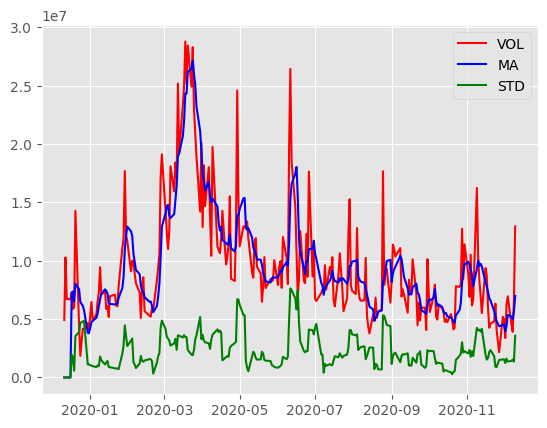

In [5]:
plt.style.use('ggplot')
plt.plot(df.index, df['Volume'], label='VOL', color='red')
plt.plot(df.index, df['MA'], label= 'MA', color='blue')
plt.plot(df.index, df['STD'], label= 'STD', color='green')

plt.legend() 
plt.show()

In [6]:
 df['feature'] = df['MA']

In [7]:
# X = df.iloc[:, :5]
# y = df.iloc[:, 5:6] 
X = df.iloc[:, :5]
y = df[['feature']]

In [8]:
X.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.847794
2019-12-12,88.000000,88.889999,87.540001,88.209999,81.341652
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.765823
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.867256
2019-12-17,88.870003,88.970001,87.470001,88.129997,81.267868


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [10]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 

In [11]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [12]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [13]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [14]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [15]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [16]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

In [17]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
# hidden_size = 2 #number of features in hidden state
# num_layers = 1 #number of stacked lstm layers
hidden_size = 10 #number of features in hidden state - independent?
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [18]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [19]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [20]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.28737
Epoch: 100, loss: 0.01800
Epoch: 200, loss: 0.01042
Epoch: 300, loss: 0.00995
Epoch: 400, loss: 0.00947
Epoch: 500, loss: 0.00903
Epoch: 600, loss: 0.00850
Epoch: 700, loss: 0.00769
Epoch: 800, loss: 0.00703
Epoch: 900, loss: 0.00671


In [21]:
# df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
# df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = ss.transform(X) #old transformers
df_y_mm = mm.transform(y) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

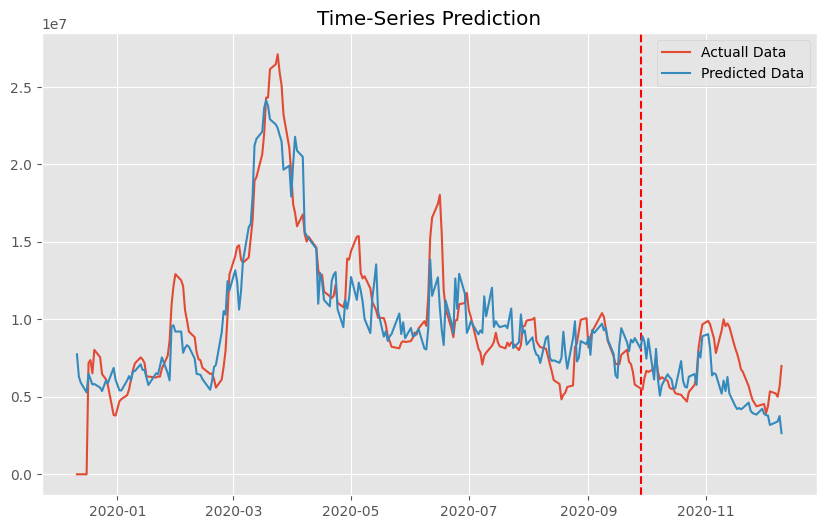

In [22]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(df.index[200], c='r', linestyle='--') #size of the training set

df['predicted'] = data_predict

plt.plot(df['feature'], label='Actuall Data') #actual plot
plt.plot(df['predicted'], label='Predicted Data') #predicted plot

# plt.plot(dataY_plot, label='Actuall Data') #actual plot
# plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [23]:
# dataY_plot
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA,STD,feature,predicted
Date,,,,,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.847794,4921900,0.0,0.000000e+00,0.0,7740787.5
2019-12-12,88.000000,88.889999,87.540001,88.209999,81.341652,10282100,0.0,0.000000e+00,0.0,6291023.0
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.765823,6714100,0.0,0.000000e+00,0.0,5908492.5
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.867256,6705600,0.0,0.000000e+00,0.0,5283917.5
2019-12-17,88.870003,88.970001,87.470001,88.129997,81.267868,7296900,7184120.0,1.947931e+06,7184120.0,6483181.5
2019-12-18,88.389999,88.849998,87.820000,87.989998,81.138786,5859200,7371580.0,1.705858e+06,7371580.0,6141119.5
2019-12-19,87.830002,88.589996,87.580002,88.519997,81.627502,6022100,6519580.0,5.831501e+05,6519580.0,5796443.0
2019-12-20,88.790001,89.000000,87.889999,88.459999,81.572182,14271500,8031060.0,3.535245e+06,8031060.0,5828018.0
2019-12-23,88.620003,88.849998,88.180000,88.230003,81.360100,4349700,7559880.0,3.894783e+06,7559880.0,5597846.0


<Axes: ylabel='Density'>

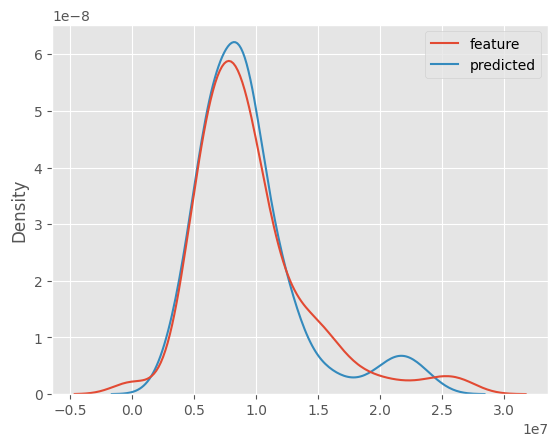

In [24]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
sns.kdeplot(data=df[['feature', 'predicted']])

In [25]:
import pylab 
import scipy.stats as stats

In [38]:
# stats.probplot(df['feature'], dist="norm", plot=pylab)
# stats.probplot(df['predicted'], dist="norm", plot=pylab)
# pylab.show()

In [39]:
# df = df.assign(feauture_norm=lambda x: (x['feature'] - x['feature'][x['feature'] > 0].min() / (x['feature'][x['feature'] > 0].max()- x['feature'][x['feature'] > 0].min())))

In [28]:
# df2 = df.reset_index()
# sns.kdeplot(data=df2['feauture_norm'])

In [29]:
# df2

In [30]:
# df2['feauture_norm']

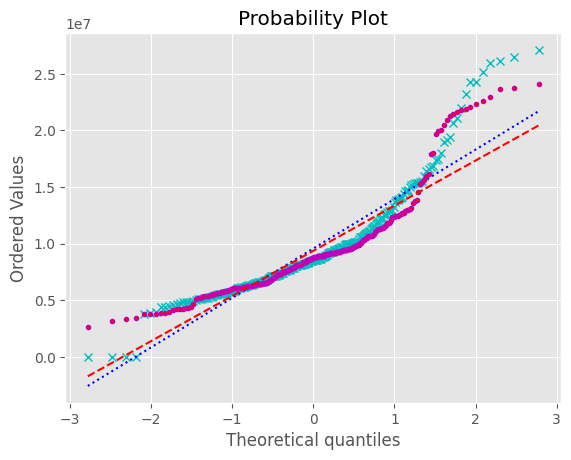

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = df['feature']
res = stats.probplot(x, plot=plt)
ax.get_lines()[0].set_marker('x')
ax.get_lines()[0].set_markerfacecolor('c')
ax.get_lines()[0].set_color('c')
ax.get_lines()[1].set_color('b')
ax.get_lines()[1].set_linestyle(':')

x = df['predicted']
res = stats.probplot(x, plot=plt)
ax.get_lines()[2].set_marker('.')
ax.get_lines()[2].set_markerfacecolor('r')
ax.get_lines()[2].set_color('m')
ax.get_lines()[3].set_color('r')
ax.get_lines()[3].set_linestyle('--')

plt.show()

In [32]:
df['diff'] = df['feature'] - df['predicted']

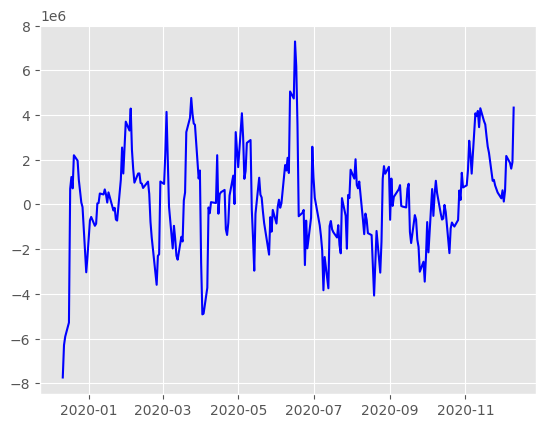

In [33]:
plt.style.use('ggplot')
plt.plot(df.index, df['diff'], color='blue')
plt.show()

In [34]:
import statsmodels.api as sm

In [35]:
# reinit for refresh
from matplotlib import pyplot as plt

<Figure size 640x480 with 0 Axes>

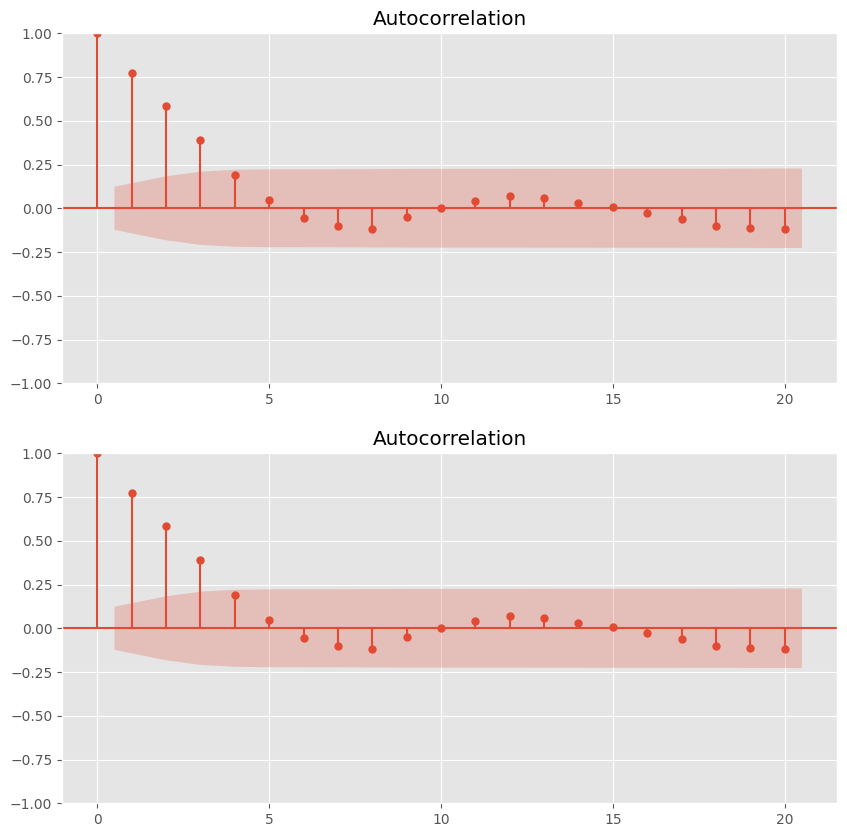

In [36]:
plt.cla()
plt.clf()

LAGS=20

fig, ax = plt.subplots(2,1,figsize=(10,10))
sm.graphics.tsa.plot_acf(df['diff'].values.squeeze(), lags=LAGS, ax=ax[0])
sm.graphics.tsa.plot_acf(df['diff'].values.squeeze(), lags=LAGS, ax=ax[1])
plt.show()